In [1]:
import sys
import os

# Step 1: Get current directory 
current_directory = os.getcwd()        # '/home/bear-b/users/jshi008/IvyProjects/FIDLA/train_WaLeF_models'

# Step 2: Get path of parent directory (one level up)
parent_directory = os.path.dirname(current_directory)    # '/home/bear-b/users/jshi008/IvyProjects/FIDLA'

# Step 3: Append parent directory to sys.path
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process
from preprocess.graph import graph_topology_5
from models.graph_water_transformer_cov import graph_water_transformer_cov

2023-07-30 15:23:35.550185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 15:23:36.844763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Parameters

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5


# ===== model parameters ======
head_size = 96*2
num_heads = 3
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = graph_water_transformer_cov_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [6]:
print(train_cov.shape, val_cov.shape, test_cov.shape, 
train_tws_reshape.shape, val_tws_reshape.shape, test_tws_reshape.shape, \
train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 12) (9634, 96, 12) (19268, 96, 12) (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) (77069, 96) (9634, 96) (19268, 96)


### Graph topology

In [7]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

In [8]:
input_shape = train_cov.shape[1:]

In [9]:
model, GCNConv = graph_water_transformer_cov(input_shape=input_shape,
                                             gcn1=gcn_unit1,
                                             gcn2=gcn_unit2,
                                             lstm_unit=lstm_units, 
                                             num_transformer_blocks=num_transformer_blocks,
                                             head_size=head_size,
                                             num_heads=num_heads,
                                             ff_dim=ff_dim, 
                                             atte_reg=atte_reg, 
                                             l1_reg=l1_reg, 
                                             l2_reg=l2_reg, 
                                             dropout=dropout,
                                             masked_value=masked_value
                                            )
model.summary()

2023-07-30 15:23:50.786889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cov_inputs (InputLayer)     [(None, 96, 12)]             0         []                            
                                                                                                  
 masking (Masking)           (None, 96, 12)               0         ['cov_inputs[0][0]']          
                                                                                                  
 multi_head_attention (Mult  (None, 96, 12)               29388     ['masking[0][0]',             
 iHeadAttention)                                                     'masking[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 96, 12)               0         ['multi_head_attention[0][

In [10]:
print(train_cov.shape, train_tws_reshape.shape, train_adj_mat.shape)
print(val_cov.shape, val_tws_reshape.shape, val_adj_mat.shape)
print(test_cov.shape, test_tws_reshape.shape, test_adj_mat.shape)

(77069, 96, 12) (77069, 5, 72) (77069, 5, 5)
(9634, 96, 12) (9634, 5, 72) (9634, 5, 5)
(19268, 96, 12) (19268, 5, 72) (19268, 5, 5)


In [11]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../saved_models/WaLeF_gtn_p.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'GCNConv': GCNConv},
                     save_best_only=True
                    )


model.fit([train_cov, train_tws_reshape, train_adj_mat], train_ws_y,
          validation_data=([test_cov, test_tws_reshape, test_adj_mat], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-30 15:25:15.650408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-30 15:25:16.712852: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8087d2bf60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-30 15:25:16.712891: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-30 15:25:16.721724: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-30 15:25:17.072381: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.09136, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 19s - loss: 0.4380 - mae: 0.3171 - val_loss: 0.0952 - val_mae: 0.0914 - 19s/epoch - 129ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.09136 to 0.08241, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 7s - loss: 0.0585 - mae: 0.0876 - val_loss: 0.0331 - val_mae: 0.0824 - 7s/epoch - 49ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.08241 to 0.07404, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 7s - loss: 0.0210 - mae: 0.0628 - val_loss: 0.0179 - val_mae: 0.0740 - 7s/epoch - 49ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.07404 to 0.06807, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 7s - loss: 0.0121 - mae: 0.0541 - val_loss: 0.0132 - val_mae: 0.0681 - 7s/epoch - 50ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.06807 to 0.06274, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 7s - loss: 0.0094 - mae: 0.0493 - val_loss: 0.0111 - val_mae: 0.0627 - 7s/epoch - 50ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.06274 to 0.05962, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 8s - loss: 0.0083 - mae: 0.0460 - v

151/151 - 8s - loss: 0.0017 - mae: 0.0175 - val_loss: 0.0025 - val_mae: 0.0295 - 8s/epoch - 50ms/step
Epoch 42/3000

Epoch 42: val_mae did not improve from 0.02949
151/151 - 7s - loss: 0.0016 - mae: 0.0171 - val_loss: 0.0024 - val_mae: 0.0299 - 7s/epoch - 49ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.02949 to 0.02820, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 7s - loss: 0.0015 - mae: 0.0166 - val_loss: 0.0022 - val_mae: 0.0282 - 7s/epoch - 49ms/step
Epoch 44/3000

Epoch 44: val_mae improved from 0.02820 to 0.02751, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 7s - loss: 0.0014 - mae: 0.0162 - val_loss: 0.0020 - val_mae: 0.0275 - 7s/epoch - 50ms/step
Epoch 45/3000

Epoch 45: val_mae did not improve from 0.02751
151/151 - 7s - loss: 0.0013 - mae: 0.0157 - val_loss: 0.0020 - val_mae: 0.0276 - 7s/epoch - 49ms/step
Epoch 46/3000

Epoch 46: val_mae improved from 0.02751 to 0.02704, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 7s - loss: 0.0

151/151 - 8s - loss: 2.0145e-04 - mae: 0.0091 - val_loss: 5.2301e-04 - val_mae: 0.0175 - 8s/epoch - 51ms/step
Epoch 85/3000

Epoch 85: val_mae did not improve from 0.01746
151/151 - 8s - loss: 2.0003e-04 - mae: 0.0091 - val_loss: 5.5410e-04 - val_mae: 0.0176 - 8s/epoch - 50ms/step
Epoch 86/3000

Epoch 86: val_mae did not improve from 0.01746
151/151 - 8s - loss: 1.9620e-04 - mae: 0.0090 - val_loss: 5.4286e-04 - val_mae: 0.0176 - 8s/epoch - 50ms/step
Epoch 87/3000

Epoch 87: val_mae improved from 0.01746 to 0.01725, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 8s - loss: 1.9415e-04 - mae: 0.0089 - val_loss: 5.2984e-04 - val_mae: 0.0172 - 8s/epoch - 50ms/step
Epoch 88/3000

Epoch 88: val_mae improved from 0.01725 to 0.01650, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 8s - loss: 1.9291e-04 - mae: 0.0089 - val_loss: 4.9137e-04 - val_mae: 0.0165 - 8s/epoch - 50ms/step
Epoch 89/3000

Epoch 89: val_mae did not improve from 0.01650
151/151 - 7s - loss: 1.9041e-04 - ma

Epoch 130/3000

Epoch 130: val_mae did not improve from 0.01452
151/151 - 7s - loss: 1.5052e-04 - mae: 0.0074 - val_loss: 4.3314e-04 - val_mae: 0.0155 - 7s/epoch - 49ms/step
Epoch 131/3000

Epoch 131: val_mae did not improve from 0.01452
151/151 - 7s - loss: 1.5049e-04 - mae: 0.0074 - val_loss: 4.3166e-04 - val_mae: 0.0154 - 7s/epoch - 49ms/step
Epoch 132/3000

Epoch 132: val_mae improved from 0.01452 to 0.01381, saving model to ../saved_models/WaLeF_gtn_p.h5
151/151 - 7s - loss: 1.5090e-04 - mae: 0.0074 - val_loss: 3.4989e-04 - val_mae: 0.0138 - 7s/epoch - 49ms/step
Epoch 133/3000

Epoch 133: val_mae did not improve from 0.01381
151/151 - 7s - loss: 1.5025e-04 - mae: 0.0074 - val_loss: 3.9713e-04 - val_mae: 0.0149 - 7s/epoch - 49ms/step
Epoch 134/3000

Epoch 134: val_mae did not improve from 0.01381
151/151 - 7s - loss: 1.4992e-04 - mae: 0.0074 - val_loss: 4.3273e-04 - val_mae: 0.0156 - 7s/epoch - 49ms/step
Epoch 135/3000

Epoch 135: val_mae improved from 0.01381 to 0.01344, saving mo

151/151 - 7s - loss: 1.3863e-04 - mae: 0.0070 - val_loss: 3.9126e-04 - val_mae: 0.0148 - 7s/epoch - 49ms/step
Epoch 177/3000

Epoch 177: val_mae did not improve from 0.01306
151/151 - 7s - loss: 1.3723e-04 - mae: 0.0069 - val_loss: 3.5330e-04 - val_mae: 0.0138 - 7s/epoch - 49ms/step
Epoch 178/3000

Epoch 178: val_mae did not improve from 0.01306
151/151 - 7s - loss: 1.3754e-04 - mae: 0.0069 - val_loss: 3.8871e-04 - val_mae: 0.0143 - 7s/epoch - 49ms/step
Epoch 179/3000

Epoch 179: val_mae did not improve from 0.01306
151/151 - 7s - loss: 1.3712e-04 - mae: 0.0069 - val_loss: 3.7694e-04 - val_mae: 0.0143 - 7s/epoch - 49ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.01306
151/151 - 7s - loss: 1.3714e-04 - mae: 0.0069 - val_loss: 3.5455e-04 - val_mae: 0.0139 - 7s/epoch - 49ms/step
Epoch 181/3000

Epoch 181: val_mae did not improve from 0.01306
151/151 - 7s - loss: 1.3684e-04 - mae: 0.0069 - val_loss: 3.7914e-04 - val_mae: 0.0146 - 7s/epoch - 49ms/step
Epoch 182/3000

Epoc

Epoch 223/3000

Epoch 223: val_mae did not improve from 0.01272
151/151 - 7s - loss: 1.3025e-04 - mae: 0.0066 - val_loss: 3.8889e-04 - val_mae: 0.0147 - 7s/epoch - 49ms/step
Epoch 224/3000

Epoch 224: val_mae did not improve from 0.01272
151/151 - 7s - loss: 1.3085e-04 - mae: 0.0067 - val_loss: 3.5843e-04 - val_mae: 0.0140 - 7s/epoch - 49ms/step
Epoch 225/3000

Epoch 225: val_mae did not improve from 0.01272
151/151 - 7s - loss: 1.3070e-04 - mae: 0.0067 - val_loss: 3.1557e-04 - val_mae: 0.0128 - 7s/epoch - 49ms/step
Epoch 226/3000

Epoch 226: val_mae did not improve from 0.01272
151/151 - 7s - loss: 1.3027e-04 - mae: 0.0066 - val_loss: 3.1875e-04 - val_mae: 0.0131 - 7s/epoch - 49ms/step
Epoch 227/3000

Epoch 227: val_mae did not improve from 0.01272
151/151 - 7s - loss: 1.2970e-04 - mae: 0.0066 - val_loss: 3.5623e-04 - val_mae: 0.0140 - 7s/epoch - 49ms/step
Epoch 228/3000

Epoch 228: val_mae did not improve from 0.01272
151/151 - 7s - loss: 1.2968e-04 - mae: 0.0066 - val_loss: 3.6472e-

Epoch 270/3000

Epoch 270: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2541e-04 - mae: 0.0064 - val_loss: 2.8483e-04 - val_mae: 0.0120 - 7s/epoch - 49ms/step
Epoch 271/3000

Epoch 271: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2528e-04 - mae: 0.0064 - val_loss: 3.4739e-04 - val_mae: 0.0137 - 7s/epoch - 49ms/step
Epoch 272/3000

Epoch 272: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2534e-04 - mae: 0.0064 - val_loss: 3.3147e-04 - val_mae: 0.0133 - 7s/epoch - 49ms/step
Epoch 273/3000

Epoch 273: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2511e-04 - mae: 0.0064 - val_loss: 3.5008e-04 - val_mae: 0.0138 - 7s/epoch - 49ms/step
Epoch 274/3000

Epoch 274: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2500e-04 - mae: 0.0064 - val_loss: 3.0722e-04 - val_mae: 0.0127 - 7s/epoch - 49ms/step
Epoch 275/3000

Epoch 275: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2550e-04 - mae: 0.0065 - val_loss: 3.5684e-


Epoch 317: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2190e-04 - mae: 0.0063 - val_loss: 2.9953e-04 - val_mae: 0.0125 - 7s/epoch - 49ms/step
Epoch 318/3000

Epoch 318: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2184e-04 - mae: 0.0063 - val_loss: 3.4782e-04 - val_mae: 0.0136 - 7s/epoch - 49ms/step
Epoch 319/3000

Epoch 319: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2187e-04 - mae: 0.0063 - val_loss: 3.3428e-04 - val_mae: 0.0131 - 7s/epoch - 49ms/step
Epoch 320/3000

Epoch 320: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2192e-04 - mae: 0.0063 - val_loss: 3.2794e-04 - val_mae: 0.0132 - 7s/epoch - 49ms/step
Epoch 321/3000

Epoch 321: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2232e-04 - mae: 0.0064 - val_loss: 3.5586e-04 - val_mae: 0.0137 - 7s/epoch - 49ms/step
Epoch 322/3000

Epoch 322: val_mae did not improve from 0.01204
151/151 - 7s - loss: 1.2121e-04 - mae: 0.0063 - val_loss: 3.3766e-04 - val_mae: 0

151/151 - 7s - loss: 1.1947e-04 - mae: 0.0062 - val_loss: 3.2307e-04 - val_mae: 0.0132 - 7s/epoch - 49ms/step
Epoch 364/3000

Epoch 364: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1944e-04 - mae: 0.0062 - val_loss: 3.5639e-04 - val_mae: 0.0139 - 7s/epoch - 49ms/step
Epoch 365/3000

Epoch 365: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1972e-04 - mae: 0.0063 - val_loss: 3.0387e-04 - val_mae: 0.0126 - 7s/epoch - 49ms/step
Epoch 366/3000

Epoch 366: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1917e-04 - mae: 0.0062 - val_loss: 3.3733e-04 - val_mae: 0.0134 - 7s/epoch - 49ms/step
Epoch 367/3000

Epoch 367: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1923e-04 - mae: 0.0062 - val_loss: 3.1290e-04 - val_mae: 0.0128 - 7s/epoch - 49ms/step
Epoch 368/3000

Epoch 368: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1862e-04 - mae: 0.0062 - val_loss: 2.7165e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 369/3000

Epoc

Epoch 411/3000

Epoch 411: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1746e-04 - mae: 0.0062 - val_loss: 3.0637e-04 - val_mae: 0.0127 - 7s/epoch - 49ms/step
Epoch 412/3000

Epoch 412: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1709e-04 - mae: 0.0062 - val_loss: 3.4682e-04 - val_mae: 0.0137 - 7s/epoch - 49ms/step
Epoch 413/3000

Epoch 413: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1752e-04 - mae: 0.0062 - val_loss: 2.7479e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 414/3000

Epoch 414: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1699e-04 - mae: 0.0062 - val_loss: 3.1764e-04 - val_mae: 0.0129 - 7s/epoch - 49ms/step
Epoch 415/3000

Epoch 415: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1750e-04 - mae: 0.0062 - val_loss: 3.2771e-04 - val_mae: 0.0132 - 7s/epoch - 49ms/step
Epoch 416/3000

Epoch 416: val_mae did not improve from 0.01161
151/151 - 7s - loss: 1.1710e-04 - mae: 0.0062 - val_loss: 3.3757e-

Epoch 458/3000

Epoch 458: val_mae did not improve from 0.01126
151/151 - 7s - loss: 1.1548e-04 - mae: 0.0061 - val_loss: 3.2226e-04 - val_mae: 0.0132 - 7s/epoch - 49ms/step
Epoch 459/3000

Epoch 459: val_mae did not improve from 0.01126
151/151 - 7s - loss: 1.1531e-04 - mae: 0.0061 - val_loss: 3.1429e-04 - val_mae: 0.0129 - 7s/epoch - 49ms/step
Epoch 460/3000

Epoch 460: val_mae did not improve from 0.01126
151/151 - 7s - loss: 1.1524e-04 - mae: 0.0061 - val_loss: 2.8167e-04 - val_mae: 0.0120 - 7s/epoch - 49ms/step
Epoch 461/3000

Epoch 461: val_mae did not improve from 0.01126
151/151 - 7s - loss: 1.1554e-04 - mae: 0.0061 - val_loss: 2.9246e-04 - val_mae: 0.0123 - 7s/epoch - 49ms/step
Epoch 462/3000

Epoch 462: val_mae did not improve from 0.01126
151/151 - 7s - loss: 1.1581e-04 - mae: 0.0061 - val_loss: 2.9331e-04 - val_mae: 0.0124 - 7s/epoch - 49ms/step
Epoch 463/3000

Epoch 463: val_mae did not improve from 0.01126
151/151 - 7s - loss: 1.1647e-04 - mae: 0.0062 - val_loss: 2.9693e-

Epoch 505/3000

Epoch 505: val_mae did not improve from 0.01124
151/151 - 7s - loss: 1.1382e-04 - mae: 0.0060 - val_loss: 3.0656e-04 - val_mae: 0.0127 - 7s/epoch - 49ms/step
Epoch 506/3000

Epoch 506: val_mae did not improve from 0.01124
151/151 - 7s - loss: 1.1426e-04 - mae: 0.0061 - val_loss: 3.2542e-04 - val_mae: 0.0133 - 7s/epoch - 49ms/step
Epoch 507/3000

Epoch 507: val_mae did not improve from 0.01124
151/151 - 7s - loss: 1.1454e-04 - mae: 0.0061 - val_loss: 2.8388e-04 - val_mae: 0.0123 - 7s/epoch - 49ms/step
Epoch 508/3000

Epoch 508: val_mae did not improve from 0.01124
151/151 - 7s - loss: 1.1352e-04 - mae: 0.0060 - val_loss: 2.6183e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 509/3000

Epoch 509: val_mae did not improve from 0.01124
151/151 - 7s - loss: 1.1368e-04 - mae: 0.0060 - val_loss: 2.9253e-04 - val_mae: 0.0125 - 7s/epoch - 49ms/step
Epoch 510/3000

Epoch 510: val_mae did not improve from 0.01124
151/151 - 7s - loss: 1.1426e-04 - mae: 0.0061 - val_loss: 2.9691e-

Epoch 552/3000

Epoch 552: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1231e-04 - mae: 0.0060 - val_loss: 2.9714e-04 - val_mae: 0.0126 - 7s/epoch - 49ms/step
Epoch 553/3000

Epoch 553: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1239e-04 - mae: 0.0060 - val_loss: 2.6621e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 554/3000

Epoch 554: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1288e-04 - mae: 0.0060 - val_loss: 3.0147e-04 - val_mae: 0.0127 - 7s/epoch - 49ms/step
Epoch 555/3000

Epoch 555: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1259e-04 - mae: 0.0060 - val_loss: 2.9313e-04 - val_mae: 0.0125 - 7s/epoch - 49ms/step
Epoch 556/3000

Epoch 556: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1297e-04 - mae: 0.0060 - val_loss: 3.1556e-04 - val_mae: 0.0130 - 7s/epoch - 49ms/step
Epoch 557/3000

Epoch 557: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1228e-04 - mae: 0.0060 - val_loss: 2.7426e-


Epoch 599: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1143e-04 - mae: 0.0060 - val_loss: 2.9825e-04 - val_mae: 0.0125 - 7s/epoch - 49ms/step
Epoch 600/3000

Epoch 600: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1112e-04 - mae: 0.0060 - val_loss: 2.7139e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 601/3000

Epoch 601: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1159e-04 - mae: 0.0060 - val_loss: 2.6263e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 602/3000

Epoch 602: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1162e-04 - mae: 0.0060 - val_loss: 2.9803e-04 - val_mae: 0.0127 - 7s/epoch - 49ms/step
Epoch 603/3000

Epoch 603: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1184e-04 - mae: 0.0060 - val_loss: 2.7677e-04 - val_mae: 0.0120 - 7s/epoch - 49ms/step
Epoch 604/3000

Epoch 604: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1097e-04 - mae: 0.0059 - val_loss: 2.8649e-04 - val_mae: 0

151/151 - 7s - loss: 1.1052e-04 - mae: 0.0060 - val_loss: 2.8638e-04 - val_mae: 0.0124 - 7s/epoch - 49ms/step
Epoch 647/3000

Epoch 647: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1019e-04 - mae: 0.0059 - val_loss: 3.0158e-04 - val_mae: 0.0126 - 7s/epoch - 49ms/step
Epoch 648/3000

Epoch 648: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1048e-04 - mae: 0.0059 - val_loss: 2.6779e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 649/3000

Epoch 649: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1051e-04 - mae: 0.0060 - val_loss: 2.7051e-04 - val_mae: 0.0118 - 7s/epoch - 48ms/step
Epoch 650/3000

Epoch 650: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1061e-04 - mae: 0.0060 - val_loss: 2.5601e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 651/3000

Epoch 651: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1014e-04 - mae: 0.0059 - val_loss: 2.9390e-04 - val_mae: 0.0125 - 7s/epoch - 49ms/step
Epoch 652/3000

Epoc

Epoch 694/3000

Epoch 694: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0936e-04 - mae: 0.0059 - val_loss: 2.7188e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 695/3000

Epoch 695: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0931e-04 - mae: 0.0059 - val_loss: 2.5601e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 696/3000

Epoch 696: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0967e-04 - mae: 0.0059 - val_loss: 2.7204e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 697/3000

Epoch 697: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0953e-04 - mae: 0.0059 - val_loss: 2.6423e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 698/3000

Epoch 698: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0926e-04 - mae: 0.0059 - val_loss: 3.0048e-04 - val_mae: 0.0128 - 7s/epoch - 50ms/step
Epoch 699/3000

Epoch 699: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0950e-04 - mae: 0.0059 - val_loss: 2.8792e-


Epoch 741: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0834e-04 - mae: 0.0059 - val_loss: 2.8815e-04 - val_mae: 0.0123 - 7s/epoch - 49ms/step
Epoch 742/3000

Epoch 742: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0875e-04 - mae: 0.0059 - val_loss: 2.8263e-04 - val_mae: 0.0122 - 7s/epoch - 49ms/step
Epoch 743/3000

Epoch 743: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0835e-04 - mae: 0.0059 - val_loss: 2.6946e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 744/3000

Epoch 744: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0843e-04 - mae: 0.0059 - val_loss: 2.8891e-04 - val_mae: 0.0123 - 7s/epoch - 49ms/step
Epoch 745/3000

Epoch 745: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0843e-04 - mae: 0.0059 - val_loss: 2.7962e-04 - val_mae: 0.0120 - 7s/epoch - 49ms/step
Epoch 746/3000

Epoch 746: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0845e-04 - mae: 0.0059 - val_loss: 2.7958e-04 - val_mae: 0

151/151 - 7s - loss: 1.0779e-04 - mae: 0.0059 - val_loss: 2.5919e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 789/3000

Epoch 789: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0775e-04 - mae: 0.0059 - val_loss: 2.7314e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 790/3000

Epoch 790: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0747e-04 - mae: 0.0058 - val_loss: 2.7868e-04 - val_mae: 0.0121 - 7s/epoch - 49ms/step
Epoch 791/3000

Epoch 791: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0761e-04 - mae: 0.0059 - val_loss: 2.7088e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 792/3000

Epoch 792: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0794e-04 - mae: 0.0059 - val_loss: 2.5872e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 793/3000

Epoch 793: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0803e-04 - mae: 0.0059 - val_loss: 2.4859e-04 - val_mae: 0.0112 - 7s/epoch - 50ms/step
Epoch 794/3000

Epoc

Epoch 836/3000

Epoch 836: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0687e-04 - mae: 0.0058 - val_loss: 2.7524e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 837/3000

Epoch 837: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0684e-04 - mae: 0.0058 - val_loss: 2.6616e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 838/3000

Epoch 838: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0660e-04 - mae: 0.0058 - val_loss: 2.8257e-04 - val_mae: 0.0121 - 7s/epoch - 49ms/step
Epoch 839/3000

Epoch 839: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0709e-04 - mae: 0.0058 - val_loss: 2.5635e-04 - val_mae: 0.0114 - 7s/epoch - 49ms/step
Epoch 840/3000

Epoch 840: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0698e-04 - mae: 0.0058 - val_loss: 2.8541e-04 - val_mae: 0.0123 - 7s/epoch - 49ms/step
Epoch 841/3000

Epoch 841: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0669e-04 - mae: 0.0058 - val_loss: 2.7550e-


Epoch 883: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0646e-04 - mae: 0.0058 - val_loss: 2.8027e-04 - val_mae: 0.0121 - 7s/epoch - 49ms/step
Epoch 884/3000

Epoch 884: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0606e-04 - mae: 0.0058 - val_loss: 2.8278e-04 - val_mae: 0.0121 - 7s/epoch - 49ms/step
Epoch 885/3000

Epoch 885: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0620e-04 - mae: 0.0058 - val_loss: 2.8714e-04 - val_mae: 0.0122 - 7s/epoch - 49ms/step
Epoch 886/3000

Epoch 886: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0643e-04 - mae: 0.0058 - val_loss: 2.8308e-04 - val_mae: 0.0121 - 7s/epoch - 49ms/step
Epoch 887/3000

Epoch 887: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0627e-04 - mae: 0.0058 - val_loss: 2.9776e-04 - val_mae: 0.0125 - 7s/epoch - 49ms/step
Epoch 888/3000

Epoch 888: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0614e-04 - mae: 0.0058 - val_loss: 2.7967e-04 - val_mae: 0

151/151 - 7s - loss: 1.0530e-04 - mae: 0.0058 - val_loss: 2.6407e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 931/3000

Epoch 931: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0577e-04 - mae: 0.0058 - val_loss: 2.9004e-04 - val_mae: 0.0122 - 7s/epoch - 49ms/step
Epoch 932/3000

Epoch 932: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0535e-04 - mae: 0.0058 - val_loss: 2.7652e-04 - val_mae: 0.0120 - 7s/epoch - 49ms/step
Epoch 933/3000

Epoch 933: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0611e-04 - mae: 0.0058 - val_loss: 2.8903e-04 - val_mae: 0.0124 - 7s/epoch - 49ms/step
Epoch 934/3000

Epoch 934: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0550e-04 - mae: 0.0058 - val_loss: 2.5675e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 935/3000

Epoch 935: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0552e-04 - mae: 0.0058 - val_loss: 2.9082e-04 - val_mae: 0.0123 - 7s/epoch - 49ms/step
Epoch 936/3000

Epoc

Epoch 978/3000

Epoch 978: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0515e-04 - mae: 0.0058 - val_loss: 2.9589e-04 - val_mae: 0.0124 - 7s/epoch - 49ms/step
Epoch 979/3000

Epoch 979: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0491e-04 - mae: 0.0058 - val_loss: 2.7561e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 980/3000

Epoch 980: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0497e-04 - mae: 0.0058 - val_loss: 2.6423e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 981/3000

Epoch 981: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0507e-04 - mae: 0.0058 - val_loss: 2.9321e-04 - val_mae: 0.0124 - 7s/epoch - 49ms/step
Epoch 982/3000

Epoch 982: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0546e-04 - mae: 0.0058 - val_loss: 2.7630e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 983/3000

Epoch 983: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.0527e-04 - mae: 0.0058 - val_loss: 2.8569e-

### Performance

In [19]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

yhat = saved_model.predict([test_cov, test_tws_reshape, test_adj_mat])

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 2s 3ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0578
RMSE = 0.0808


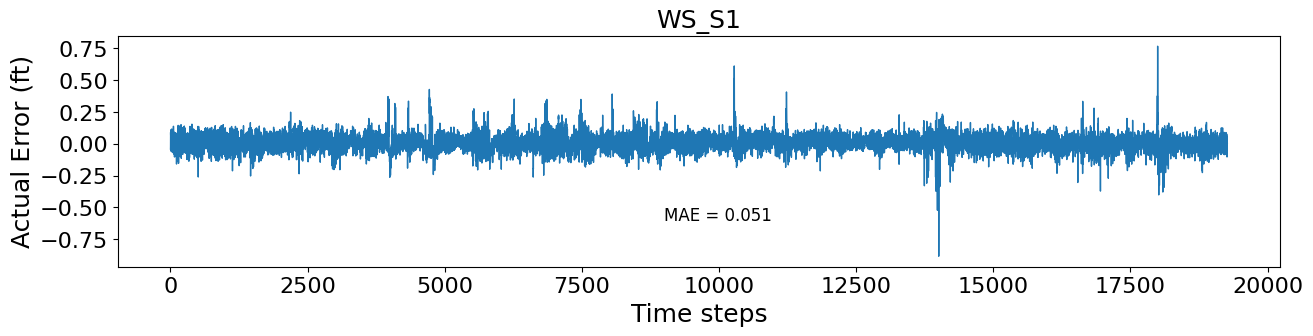

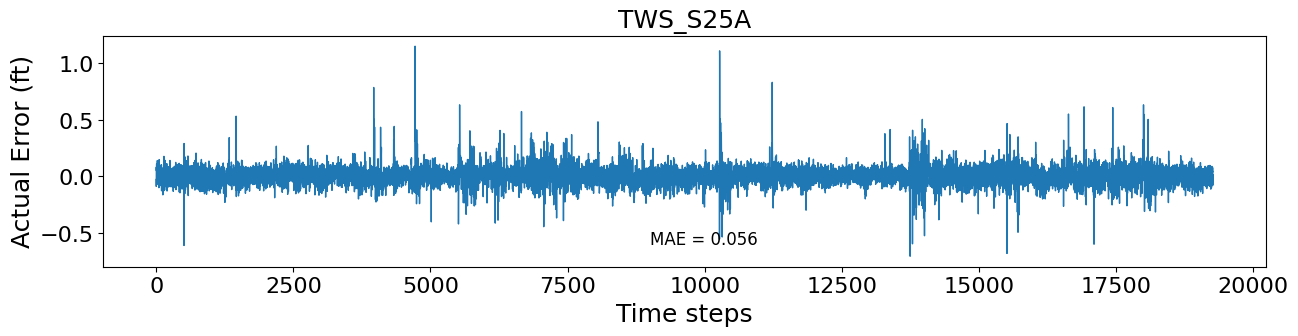

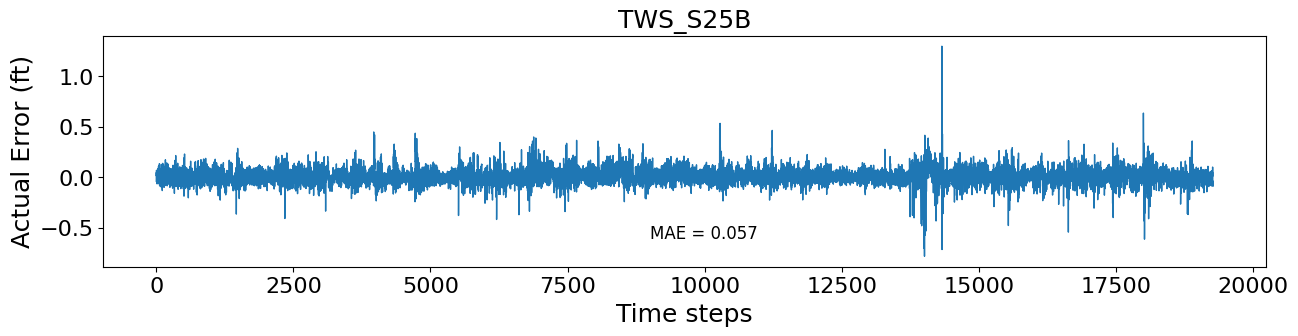

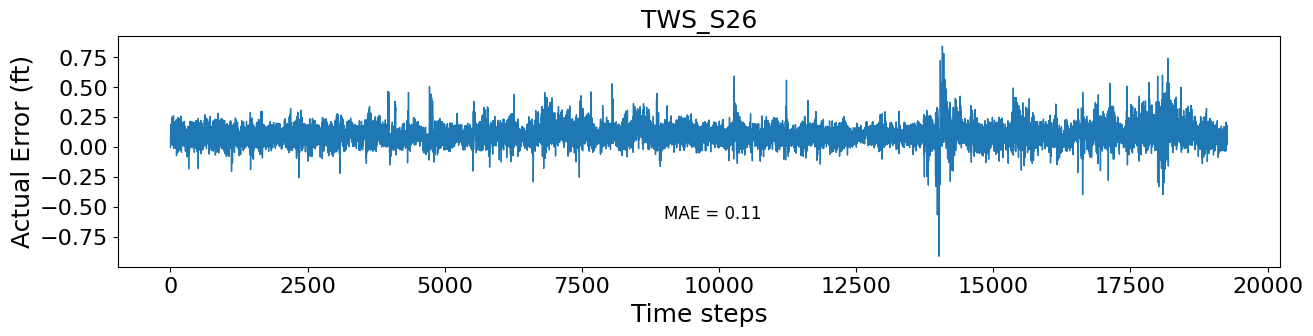

In [21]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [22]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
8
(19268,)
30
(19268,)
17
(19268,)
40


In [23]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
4
(19268,)
22
(19268,)
5
(19268,)
35


In [24]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
4
(19268,)
8
(19268,)
12
(19268,)
5
